In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from timeit import default_timer as timer

In [2]:
# returns i-th lagrange basis polynomial at t via interpolation points x
def L(i, t, x):
    n = len(x) - 1
    dummy = 1

    for j in range(n+1):
        if j != i:
            dummy *= (t - x[j])/(x[i] - x[j])

    return dummy

# calculates closed newton-cotes formula of order n on interval [a, b]
def Q(n):
    a, b = sp.symbols('a b')
    t = sp.Symbol('t')

    h = (b - a)/n
    x = [a + h*i for i in range(n+1)]

    # y_i = f(x_i)
    y = sp.IndexedBase('y')
    y = [y[i] for i in range(n+1)]

    dummy = 0

    for i in range(n+1):
        weight = sp.integrate(L(i, t, x), (t, a, b))
        weight = sp.factor(weight)

        dummy += weight * y[i]

    return sp.factor(dummy)

In [3]:
n = 4

for i in range(n+1):
    name  = "Q_{} = ".format(i)
    value = Q(i)
    
    display(name, value)

'Q_0 = '

-(a - b)*y[0]

'Q_1 = '

-(a - b)*(y[0] + y[1])/2

'Q_2 = '

-(a - b)*(y[0] + 4*y[1] + y[2])/6

'Q_3 = '

-(a - b)*(y[0] + 3*y[1] + 3*y[2] + y[3])/8

'Q_4 = '

-(a - b)*(7*y[0] + 32*y[1] + 12*y[2] + 32*y[3] + 7*y[4])/90

In [4]:
# ---------------------------------------------------------------- #

# integrates f on [a, b] via trapezium rule with equidistant nodes of distance h
def Q_1(h, f, a, b):
    n = (b-a)/h
    n = int(n)
    x = np.linspace(a, b, n+1)

    S_11 = f(a)
    S_12 = np.sum(f(x[1:n]))
    S_13 = f(b)

    return h/2 * (S_11 + 2*S_12 + S_13)

# ---------------------------------------------------------------- #

# integrates f on [a, b] via simpson's rule with equidistant nodes of distance h
def Q_2(h, f, a, b):
    n = (b-a)/h
    n = int(n)
    x = np.linspace(a, b, n+1)

    S_11 = f(a)
    S_12 = np.sum(f(x[1:n]))
    S_13 = f(b)
    S_2  = np.sum(f((x[0:n] + x[1:n+1])/2))

    return h/6 * (S_11 + 4*S_2 + 2*S_12 + S_13)

# ---------------------------------------------------------------- #

# integrates f on [a, b] via mile's rule with equidistant nodes of distance h
def Q_4(h, f, a, b):
    n = (b-a)/h
    n = int(n)
    x = np.linspace(a, b, n+1)

    S_11 = f(a)
    S_12 = np.sum(f(x[1:n]))
    S_13 = f(b)
    S_2  = np.sum(f((x[0:n] + x[1:n+1])/2))
    S_41 = np.sum(f((3*x[0:n] + x[1:n+1])/4))
    S_42 = np.sum(f((x[0:n] + 3*x[1:n+1])/4))

    return h/90 * (7*S_11 + 32*S_41 + 12*S_2 + 14*S_12 + 32*S_42 + 7*S_13)

# ---------------------------------------------------------------- #

# returns summated quadrature formula of order m
def Q(m):
    if m == 1:
        return Q_1
    if m == 2:
        return Q_2
    if m == 4:
        return Q_4

# ---------------------------------------------------------------- #

In [5]:
# ---------------------------------------------------------------- #

# inefficient implementation (with recursion)

def richardson_extrapolation_1(h_0, f, a, b, r):
    return recursion(h_0, f, a, b, 0, r)

def recursion(h_0, f, a, b, j, i):
    h_j = h_0/2**j

    if i == 0:
        return Q_1(h_j, f, a, b)

    else:
        tmp_1 = recursion(h_0, f, a, b, j,   i-1)
        tmp_2 = recursion(h_0, f, a, b, j+1, i-1)

        return tmp_1 + (tmp_1 - tmp_2)/(1/2**(i*2) - 1)

# ---------------------------------------------------------------- #

# efficient implementation (with loops)

def richardson_extrapolation_2(h_0, f, a, b, r):
    A = np.zeros((r+1, r+1))

    A[0,0] = Q_1(h_0, f, a, b)

    for j in range(r):
        h_j = h_0/2**j
        n_j = int((b-a)/h_j)
        x = np.linspace(a, b, n_j+1)

        A[j+1, 0] = 1/2 * (A[j, 0] + h_j * np.sum(f((x[0:n_j] + x[1:n_j+1])/2)))

    for i in range(1, r+1):
        for j in range(r+1-i):
            A[j, i] = A[j, i-1] + (A[j, i-1] - A[j+1, i-1])/(1/2**(i*2) - 1)

    return A[0, -1]

# ---------------------------------------------------------------- #

# returns summated quadrature formula of order m
def Q(m):
    r = np.log2(m)
    r = int(r)

    def dummy(h_0, f, a, b):
        return richardson_extrapolation_2(h_0, f, a, b, r)

    return dummy

# ---------------------------------------------------------------- #

In [6]:
# functions .............. vector                         of functions
# indefinite_integrals ... vector of indefinite integrals of functions
# intervals .............. vector of intervals            of functions
# names .................. matrix of names                of functions times intervals times quadrature types

# quadrature_types ... array of types of summated quadrature formula:
# 1 ... trapezium,
# 2 ... simpson,
# 4 ... mile;

# with_references ... array of bools whether quadrature_types should have references

# n_max + 1 ... maximum number of quadrature knots

# ---------------------------------------------------------------- #

# plots quratrature error vs. distance between quadrature knots
def plot_1(functions, indefinite_integrals, intervals, names, quadrature_types, with_references, n_max):
    plt.figure()

    legend = []

    for m, with_reference in zip(quadrature_types, with_references):
        for a, b in intervals:
            # array of distances between quadrature knots
            H = (b-a)/np.array(range(1, n_max+1))

            for f, F in zip(functions, indefinite_integrals):
                # quadrature result and definite integral
                approximate = np.array([Q(m)(h, f, a, b) for h in H])
                exact       = F(b) - F(a)
                # quadrature error
                error = abs(exact - approximate)

                plt.loglog(H, error, 'o-')

        for name_space in names:
            for name in name_space:
                legend += ["$\epsilon_\cdot^{}(".format(m) + name + ")$"]

        if with_reference:
            # convergence speed factor
            p = 2*int(np.log2(m) + 1)
            # convergence speed reference
            reference = H**p

            plt.loglog(H, reference)

            legend += ["id$^{{-{}}}$".format(p)]

    plt.legend((*legend,))
    plt.grid(linestyle = ':')
    plt.show()

# ---------------------------------------------------------------- #

# r_max ... maximal extrapolation degree of summated trapezium rule
# k_max ... maximal index in romberg sequence

# plots quratrature error vs. number of function evaluations
def plot_2(function, indefinite_integral, interval, name, r_max, k_max):
    fig, ax = plt.subplots()

    legend = []

    f = function
    F = indefinite_integral

    a = interval[0]
    b = interval[1]

    for r in range(r_max+1):
        m = 2**r

        # array of number of quadrature knots + 1
        n = 2**np.array(range(k_max+1))
        # array of distances between quadrature knots
        h = (b-a)/n

        # array of number of function evaluations
        cost = n*m + 1

        # quadrature result and definite integral
        approximate = np.array([Q(m)(h[k], f, a, b) for k in range(k_max+1)])
        exact       = F(b) - F(a)
        # quadrature error
        error = abs(exact - approximate)

        plt.loglog(cost, error, 'o-')

        legend += ["$m = 2^{}$".format(r)]

    ax.set_xlabel("$\# Q_h^m$")
    ax.set_ylabel("$\epsilon_h^m(" + name + ")$")

    plt.legend((*legend,))
    plt.grid(linestyle = ':')
    plt.show()

# ---------------------------------------------------------------- #

In [7]:
# ---------------------------------------------------------------- #

def g(k):
    def dummy(x):
        return np.sqrt(x)**k

    return dummy

def G(k):
    def dummy(x):
        return 2/(k+2) * np.sqrt(x)**(k+2)
    
    return dummy

# ---------------------------------------------------------------- #

def f(x):
    return np.sin(np.pi * x)

def F(x):
    return -np.cos(np.pi * x)/np.pi

# ---------------------------------------------------------------- #

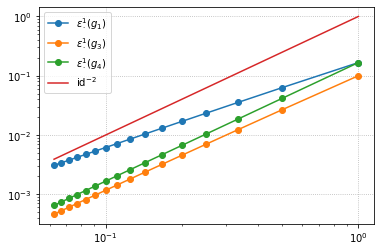

In [8]:
a = 0
b = 1

k_max = 4
indices = []
for k in range(k_max+1):
    if not k in [0, 2]:
        indices += [k]

functions            = [g(k)              for k in indices]
indefinite_integrals = [G(k)              for k in indices]
names                = [["g_{}".format(k) for k in indices]]
intervals            = [(a, b)]
quadrature_types     = [1]
with_references      = [True]
n_max                = 16

plot_1(functions, indefinite_integrals, intervals, names, quadrature_types, with_references, n_max)

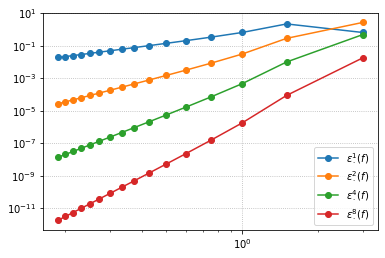

In [9]:
a = 0
b = 3

r_max = 3

functions            = [f]
indefinite_integrals = [F]
intervals            = [(a, b)]
names                = ["f"]
quadrature_types     = [2**r for r in range(r_max+1)]
with_references      = [False] * (r_max+1)
n_max                = 16

plot_1(functions, indefinite_integrals, intervals, names, quadrature_types, with_references, n_max)

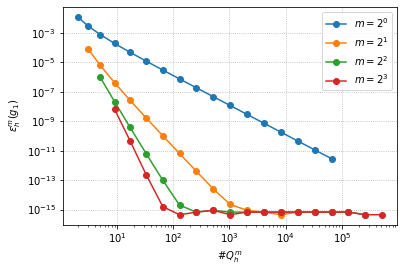

In [10]:
a = 1
b = 2

function            = g(1)
indefinite_integral = G(1)
interval            = (a, b)
name                = "g_1"
r_max               = 3
k_max               = 16

plot_2(function, indefinite_integral, interval, name, r_max, k_max)

In [11]:
def time(h_0, f, a, b, r_max):
    T = []

    for r in range(r_max+1):
        start = timer()
        v_1 = richardson_extrapolation_1(h_0, f, a, b, r)
        end = timer()
        t_1 = end - start

        start = timer()
        v_2 = richardson_extrapolation_2(h_0, f, a, b, r)
        end = timer()
        t_2 = end - start

        T += [[v_1, t_1, v_2, t_2]]

    T = np.array(T)
    T = pd.DataFrame(T)

    return T

In [12]:
def alien_1(x):
    return np.exp(-x**2)

def alien_2(x):
    return np.sin(x)/x

def alien_3(x):
    return np.cos(x)/x

In [13]:
h_0   = 1
f     = alien_1
a     = 0
b     = 1
r_max = 10

digit = 14
pd.set_option("display.precision", digit)

T = time(h_0, f, a, b, r_max)
print("Extrapolation results and calculation times:", "\n")
print(T)

print("\n", "----------------------------------------------------------------", "\n")

print("Direct results:", "\n")
print("Q_1:", Q_1(h_0, f, a, b))
print("Q_2:", Q_2(h_0, f, a, b))
print("Q_4:", Q_4(h_0, f, a, b))

Extrapolation results and calculation times: 

                   0          1                 2          3
0   0.68393972058572  0.0002587  0.68393972058572  0.0000706
1   0.74718042890951  0.0001254  0.74718042890951  0.0000942
2   0.74683370984975  0.0001729  0.74683370984975  0.0001290
3   0.74682401848228  0.0003366  0.74682401848228  0.0002072
4   0.74682413309509  0.0010272  0.74682413309509  0.0003538
5   0.74682413281224  0.0013400  0.74682413281224  0.0002207
6   0.74682413281243  0.0021929  0.74682413281243  0.0002596
7   0.74682413281243  0.0044576  0.74682413281243  0.0002983
8   0.74682413281243  0.0116581  0.74682413281243  0.0003493
9   0.74682413281243  0.0198285  0.74682413281243  0.0005548
10  0.74682413281243  0.0440120  0.74682413281243  0.0004480

 ---------------------------------------------------------------- 

Direct results: 

Q_1: 0.6839397205857212
Q_2: 0.7471804289095104
Q_4: 0.7468337098497525
